# SWOT denoising module: improve convergence of var_reg

* Emmanuel Cosme
* May 2018


## Descriptions

This notebook examines the convergence of the variational regularization denoising. We compare the former version of the module (implementing the iterations solving the problem in one shot) and a updated version of the module, where the loops are splitted into a series of loops implementing the iterations with increasing orders and increasing penalization parameters.
Initially, this work was developed to speed up convergence. It actually showed that in the previous version, there was no convergence at all in many cases (or more precisely, that the final field was very close to the one after the Gaussian preconditioning), and that the new approach improves convergence. But not CPU time...



## 0. Imports, input files, plots

In [1]:
#from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import time

import SWOTdenoise_orig as swotd_orig
import SWOTdenoise as swotd
#filedir = '/Users/cosme/data/NATL60/MED-BOX/'
#filename = filedir+'MED_1km_nogap_FMA13_swotFastPhase_BOX_c01_p009.nc'
filedir = '/Users/cosme/data/NATL60/SWOT_fast_sampling_simulation_cycle1_passes/'
filename = filedir+'MED_fastPhase_1km_swotFAST_c01_p009.nc'
filename_den = filedir+'MED_fastPhase_1km_swotFAST_c01_p009_denoised.nc'   # created by the module

###  A function for plots
This function plots a SSH field as read in a SWOT file.
The function calls the fill_nadir_gap function of the SWOTdenoise module, to clearly show the gap. Otherwise, pyplot fills the gap by crudely interpolating the data between the two swaths.

In [2]:
vmin=-0.3
vmax=-0.1
def splot(sshin, vmin=vmin, vmax=vmax):
    _, lon, lat, x_ac, time = swotd.read_data(filename, 'SSH_obs', 'lon', 'lat', 'x_ac', 'time')
    ssh_f, lon_f, lat_f, x_ac_f = swotd.fill_nadir_gap(sshin, lon, lat, x_ac, time)
    #cs=plt.pcolormesh(lon_f, lat_f, ssh_f, vmin=vmin, vmax=vmax)
    cs=plt.pcolormesh(lon_f, lat_f, ssh_f)
    plt.colorbar(cs)

## 1. Read data

Below we read the noisy SSH, the model SSH (noise-free), and the noisy SSH filtered similarly to the preconditioning of the regularization method (for later comparison).

In [3]:
ssh, lon, lat, x_ac, time = swotd.read_data(filename, 'SSH_obs', 'lon', 'lat', 'x_ac', 'time')
ssh_m, lon, lat, x_ac, time = swotd.read_data(filename, 'SSH_model', 'lon', 'lat', 'x_ac', 'time')
ssh_g = swotd_orig.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='gaussian', param=10.)
ssh_f, lon_f, lat_f, x_ac_f = swotd.fill_nadir_gap(ssh, lon, lat, x_ac, time)

## 2. Denoising: First-order regularization
Here we use the regularization filter penalizing the first order derivatives only. First, using the former module version. Then, the new version. The iteration loop is divided in 8 here. The $\lambda$ parameter is 50. The loops are recursively solved with parameters [  1.   2.   3.   5.   9.  16.  29.  50.] with decreasing convergence criteria (from 1e-5 for 1, to 1e-16 for 50). 

In [4]:
%time ssh_den_orig = swotd_orig.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg', param=(20.,0,0), epsilon=1.e-6, itermax=500 )

500 60.9066597889
CPU times: user 3.02 s, sys: 25.5 ms, total: 3.05 s
Wall time: 3.04 s


In [5]:
%time ssh_den = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg', param=(20.,0,0), epsilon=1.e-6, itermax=500, pc_method='boxcar', pc_param=3, nsub=4 )

Method: var_reg
CPU times: user 24.5 s, sys: 770 ms, total: 25.3 s
Wall time: 24.8 s


### Plots
We plot the difference with the preconditioned field to examine the effects of the regularization method.

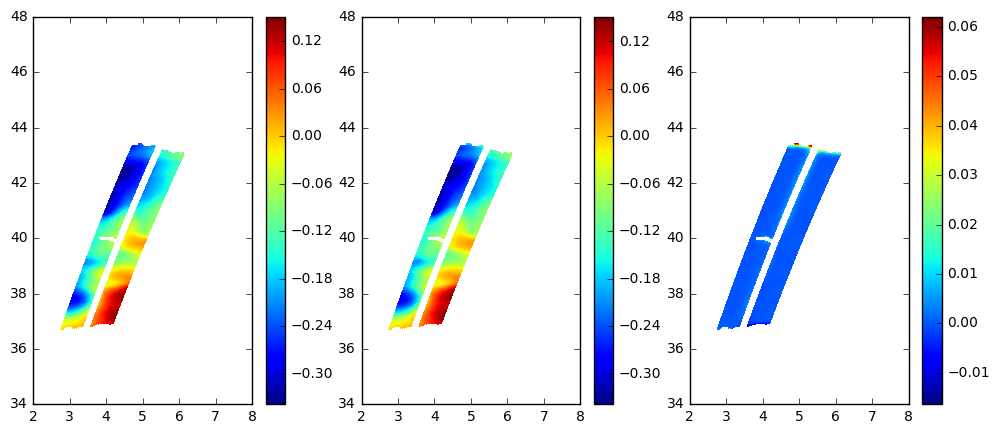

In [6]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
splot(ssh_den_orig, vmin=-0.18, vmax=-0.12)
#plt.axis([2, 7, 36, 44])
plt.subplot(1,3,2)
splot(ssh_den, vmin=-0.18, vmax=-0.12)
#plt.axis([2, 7, 36, 44])
plt.subplot(1,3,3)
splot(ssh_den-ssh_den_orig, vmin=-0.005, vmax=0.002)
#plt.axis([2, 7, 36, 44])

## Denoising: Second-order regularization filter

We proceed similarly with a second order regularization only. The convergence criterium is reduced.

In [8]:
%time ssh_den_orig = swotd_orig.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg', param=(20,200,0), epsilon=1.e-12, itermax=1000 )

1000 25757127.6203
CPU times: user 5.88 s, sys: 38.8 ms, total: 5.92 s
Wall time: 5.92 s


In [9]:
%time ssh_den = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg', param=(20,200,0), epsilon=1.e-12, itermax=1000 )

Method: var_reg
CPU times: user 2min 30s, sys: 1.09 s, total: 2min 31s
Wall time: 2min 31s


### Plots
SSH denoised - SSH denoised with gaussian filter, like the preconditioning.
Left: original module version. Middle: new version.

Right: SSH gaussian filtered.

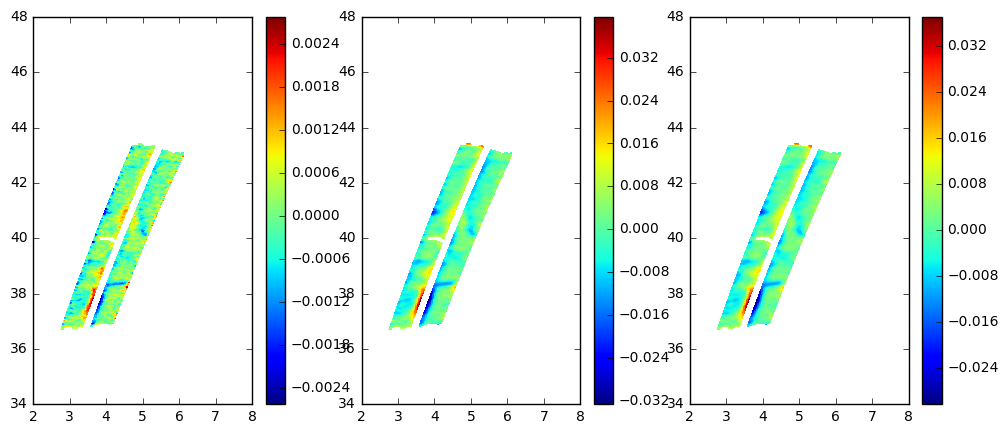

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
splot(ssh_den_orig-ssh_g)
plt.subplot(1,3,2)
splot(ssh_den-ssh_g)
plt.subplot(1,3,3)
splot(ssh_den - ssh_den_orig)
#cs=plt.pcolormesh(ssh_den-ssh_den_orig)
#plt.colorbar(cs)

##### Conclusion

A direct minimization with the initial parameter has no effect. The resulting is basically similar to the one obtained with the Gaussian preconditioning (see color scale of the left). On the contrary, the parameter splitting seems efficient: it involves a significant number of iterations and larger adjustments (notice that the maximum number of iterations has been reached). **This is a clear indication that in the previous module version, the iteration rate ($\tau$) is too small, so that the increment is small enough to be fulfill the convergence criterium.** Iterations stops before significant effect of the method. For completeness, let us look at Laplacians.

### Laplacians
From SSH model, SSH gaussian, SSH denoised with previous module version, and denoised with updated version.

In [13]:
ssh_mf, lon_f, lat_f, _  = swotd.fill_nadir_gap(ssh_m, lon, lat, x_ac, time)
lap_mf = swotd.laplacian(ssh_mf)
lap_mf = np.ma.array(lap_mf, mask = ssh_mf.mask, fill_value = 1e9 )

ssh_gf, _, _, _  = swotd.fill_nadir_gap(ssh_g, lon, lat, x_ac, time)
lap_gf = swotd.laplacian(ssh_gf)
lap_gf = np.ma.array(lap_gf, mask = ssh_gf.mask, fill_value = 1e9 )

ssh_vrf_orig, _, _, _  = swotd.fill_nadir_gap(ssh_den_orig, lon, lat, x_ac, time)
lap_vrf_orig = swotd.laplacian(ssh_vrf_orig)
lap_vrf_orig = np.ma.array(lap_vrf_orig, mask = ssh_vrf_orig.mask, fill_value = 1e9 )

ssh_vrf, _, _, _  = swotd.fill_nadir_gap(ssh_den, lon, lat, x_ac, time)
lap_vrf = swotd.laplacian(ssh_vrf)
lap_vrf = np.ma.array(lap_vrf, mask = ssh_vrf.mask, fill_value = 1e9 )

(36, 44)

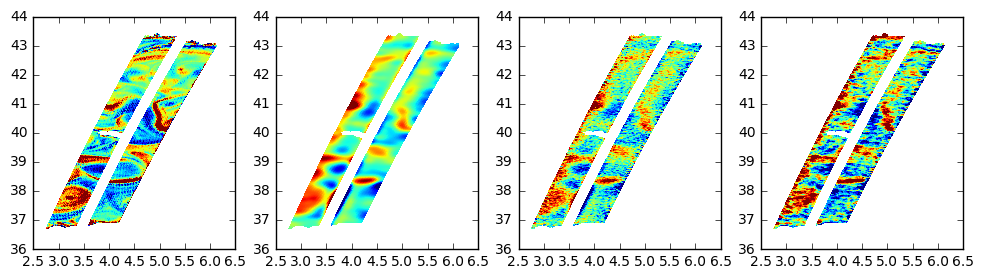

In [14]:
vmin1=-3e-4
vmax1=3e-4
plt.figure(figsize=(12,3))
#
plt.subplot(1,4,1)
cs=plt.pcolormesh(lon_f, lat_f, lap_mf,vmin=vmin1,vmax=vmax1)
plt.xlim((2.5,6.5))
plt.ylim((36,44))
#plt.colorbar(cs)
#
plt.subplot(1,4,2)
cs=plt.pcolormesh(lon_f, lat_f, lap_gf,vmin=vmin1,vmax=vmax1)
plt.xlim((2.5,6.5))
plt.ylim((36,44))
#plt.colorbar(cs)
#
plt.subplot(1,4,3)
cs=plt.pcolormesh(lon_f, lat_f, lap_vrf_orig,vmin=vmin1,vmax=vmax1)
plt.xlim((2.5,6.5))
plt.ylim((36,44))
#plt.colorbar(cs)
#
plt.subplot(1,4,4)
cs=plt.pcolormesh(lon_f, lat_f, lap_vrf,vmin=vmin1,vmax=vmax1)
plt.xlim((2.5,6.5))
plt.ylim((36,44))
#plt.colorbar(cs)

### Conclusion
The difference between the former and the new module versions is even clearer with laplacians.

## Denoising: Third-order

The same with the third-order regularization.

In [22]:
%time ssh_den_orig = swotd_orig.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg', param=(1,100,10000), epsilon=1.e-16, itermax=1000 )

1000 154246122413.0
CPU times: user 6.1 s, sys: 45.3 ms, total: 6.15 s
Wall time: 6.15 s


In [23]:
%time ssh_den = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg', param=(1,100,10000), epsilon=1.e-16, itermax=1000 )

Method: var_reg
CPU times: user 2min 42s, sys: 1.14 s, total: 2min 43s
Wall time: 2min 43s


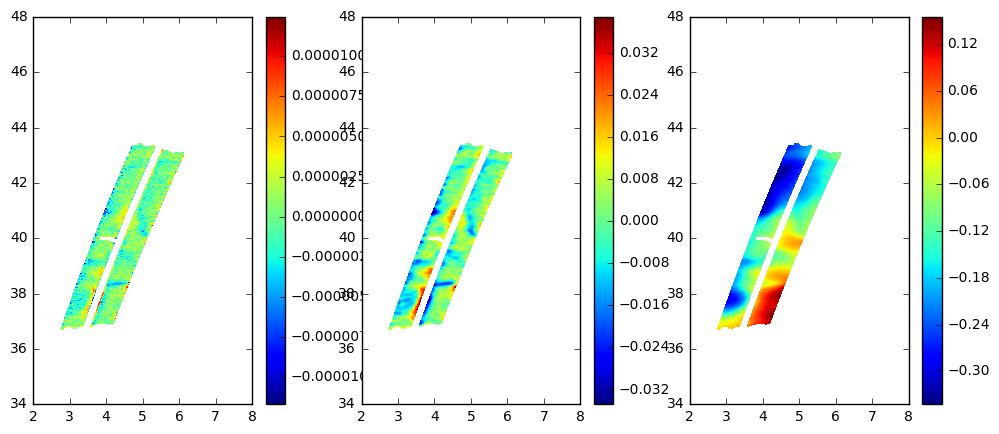

In [24]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
splot(ssh_den_orig-ssh_g)
plt.subplot(1,3,2)
splot(ssh_den-ssh_g)
plt.subplot(1,3,3)
splot(ssh_den)
#cs=plt.pcolormesh(ssh_den-ssh_den_orig)
#plt.colorbar(cs)

### First conclusion
Again, the former module version has no effect: the result is similar to the preconditioned field. What about Laplacians?

In [25]:
ssh_mf, lon_f, lat_f, _  = swotd.fill_nadir_gap(ssh_m, lon, lat, x_ac, time)
lap_mf = swotd.laplacian(ssh_mf)
lap_mf = np.ma.array(lap_mf, mask = ssh_mf.mask, fill_value = 1e9 )

ssh_gf, _, _, _  = swotd.fill_nadir_gap(ssh_g, lon, lat, x_ac, time)
lap_gf = swotd.laplacian(ssh_gf)
lap_gf = np.ma.array(lap_gf, mask = ssh_gf.mask, fill_value = 1e9 )

ssh_vrf_orig, _, _, _  = swotd.fill_nadir_gap(ssh_den_orig, lon, lat, x_ac, time)
lap_vrf_orig = swotd.laplacian(ssh_vrf_orig)
lap_vrf_orig = np.ma.array(lap_vrf_orig, mask = ssh_vrf_orig.mask, fill_value = 1e9 )

ssh_vrf, _, _, _  = swotd.fill_nadir_gap(ssh_den, lon, lat, x_ac, time)
lap_vrf = swotd.laplacian(ssh_vrf)
lap_vrf = np.ma.array(lap_vrf, mask = ssh_vrf.mask, fill_value = 1e9 )

(36, 44)

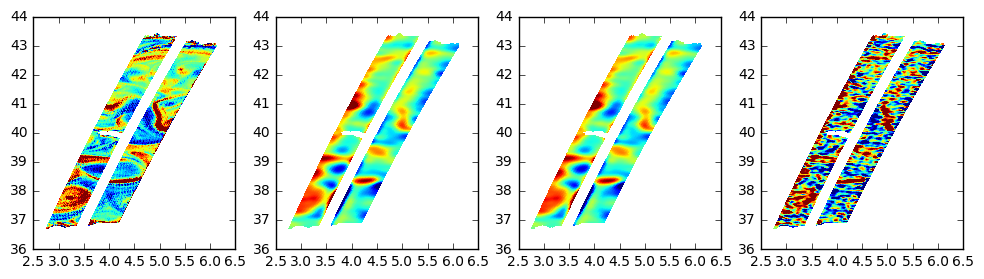

In [26]:
vmin1=-3e-4
vmax1=3e-4
plt.figure(figsize=(12,3))
#
plt.subplot(1,4,1)
cs=plt.pcolormesh(lon_f, lat_f, lap_mf,vmin=vmin1,vmax=vmax1)
plt.xlim((2.5,6.5))
plt.ylim((36,44))
#plt.colorbar(cs)
#
plt.subplot(1,4,2)
cs=plt.pcolormesh(lon_f, lat_f, lap_gf,vmin=vmin1,vmax=vmax1)
plt.xlim((2.5,6.5))
plt.ylim((36,44))
#plt.colorbar(cs)
#
plt.subplot(1,4,3)
cs=plt.pcolormesh(lon_f, lat_f, lap_vrf_orig,vmin=vmin1,vmax=vmax1)
plt.xlim((2.5,6.5))
plt.ylim((36,44))
#plt.colorbar(cs)
#
plt.subplot(1,4,4)
cs=plt.pcolormesh(lon_f, lat_f, lap_vrf,vmin=vmin1,vmax=vmax1)
plt.xlim((2.5,6.5))
plt.ylim((36,44))
#plt.colorbar(cs)

### Conclusion
Similar to second order.